In [ ]:
!pip install deap


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from deap import base, creator, tools, algorithms
import random
import warnings
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")


In [ ]:

df = pd.read_csv('/content/AmesHousing.csv')


print("Shape:", df.shape)
print(df.dtypes.value_counts())
df.head()



Shape: (2930, 82)
object     43
int64      28
float64    11
Name: count, dtype: int64


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [ ]:
# total null elements

df.isnull().sum()[df.isnull().sum() > 0]

,0
Lot Frontage,490
Alley,2732
Mas Vnr Type,1775
Mas Vnr Area,23
Bsmt Qual,80
Bsmt Cond,80
Bsmt Exposure,83
BsmtFin Type 1,80
BsmtFin SF 1,1
BsmtFin Type 2,81


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

missing_percentage = df.isnull().mean() * 100

# Drop columns with >50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
df = df.drop(columns=columns_to_drop)

print(f"Dropped columns with >50% missing values: {list(columns_to_drop)}")

for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

Dropped columns with >50% missing values: ['Alley', 'Mas Vnr Type', 'Pool QC', 'Fence', 'Misc Feature']


In [ ]:

print("Shape:", df.shape)
print(df.dtypes.value_counts())
df.head()



Shape: (2930, 77)
int64      66
float64    11
Name: count, dtype: int64


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,5,141.0,31770,1,0,3,0,...,0,0,0,0,0,5,2010,9,4,215000
1,2,526350040,20,4,80.0,11622,1,3,3,0,...,0,0,120,0,0,6,2010,9,4,105000
2,3,526351010,20,5,81.0,14267,1,0,3,0,...,0,0,0,0,12500,6,2010,9,4,172000
3,4,526353030,20,5,93.0,11160,1,3,3,0,...,0,0,0,0,0,4,2010,9,4,244000
4,5,527105010,60,5,74.0,13830,1,0,3,0,...,0,0,0,0,0,3,2010,9,4,189900


In [ ]:


# Define class labels
classes = {0: 'Cheap', 1: 'Expensive'}




In [ ]:
X = df.drop('SalePrice', axis=1)
y = (df['SalePrice'] > df['SalePrice'].median()).astype(int)
print(f"🏠 House Price median : {df['SalePrice'].median()}")

print("\n🏠 House Price Distribution :")
print(y.value_counts().rename({0: "Cheap (0)", 1: "Expensive (1)"}))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


🏠 House Price median : 160000.0

🏠 House Price Distribution :
SalePrice
Cheap (0)        1467
Expensive (1)    1463
Name: count, dtype: int64


In [ ]:
# Evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    }


models = {
    "SVM": SVC(kernel='linear', C=1),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)

}




🔍 Performance on All Features

📊 Classification Report for SVM (All Features):
              precision    recall  f1-score   support

       Cheap       0.94      0.93      0.94       427
   Expensive       0.94      0.95      0.94       452

    accuracy                           0.94       879
   macro avg       0.94      0.94      0.94       879
weighted avg       0.94      0.94      0.94       879



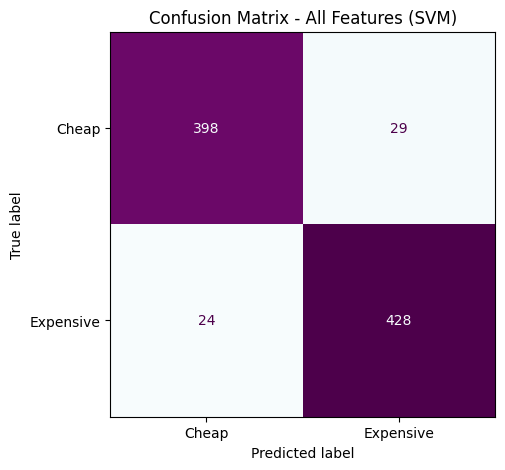


📊 Classification Report for KNN (All Features):
              precision    recall  f1-score   support

       Cheap       0.90      0.94      0.92       427
   Expensive       0.94      0.90      0.92       452

    accuracy                           0.92       879
   macro avg       0.92      0.92      0.92       879
weighted avg       0.92      0.92      0.92       879



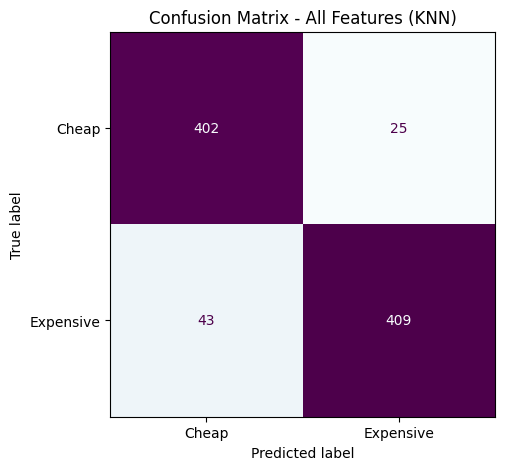


📊 Classification Report for Random Forest (All Features):
              precision    recall  f1-score   support

       Cheap       0.94      0.96      0.95       427
   Expensive       0.96      0.94      0.95       452

    accuracy                           0.95       879
   macro avg       0.95      0.95      0.95       879
weighted avg       0.95      0.95      0.95       879



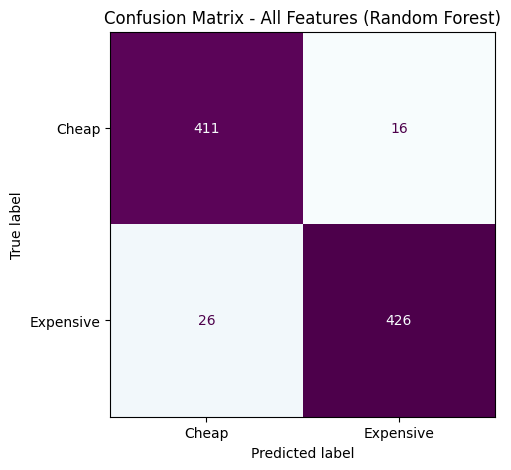


Debug - results_all structure:
{'SVM': {'accuracy': 0.9397042093287827, 'precision': 0.936542669584245, 'recall': 0.9469026548672567, 'f1_score': 0.9416941694169417}, 'KNN': {'accuracy': 0.9226393629124005, 'precision': 0.9423963133640553, 'recall': 0.9048672566371682, 'f1_score': 0.9232505643340858}, 'Random Forest': {'accuracy': 0.9522184300341296, 'precision': 0.9638009049773756, 'recall': 0.9424778761061947, 'f1_score': 0.9530201342281879}}

✅ Formatted Results After All Features Evaluation:
                       Model  Accuracy  Precision    Recall  F1-score
SVM                      SVM  0.939704   0.936543  0.946903  0.941694
KNN                      KNN  0.922639   0.942396  0.904867  0.923251
Random Forest  Random Forest  0.952218   0.963801  0.942478  0.953020


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\n🔍 Performance on All Features")
results_all = {}

for name, model in models.items():
    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store metrics
    results_all[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

    # === Classification Report ===
    print(f"\n📊 Classification Report for {name} (All Features):")
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='BuPu', colorbar=False)
    plt.title(f"Confusion Matrix - All Features ({name})")
    plt.show()

# === Convert to DataFrame ===
print("\nDebug - results_all structure:")
print(results_all)

all_results_df = pd.DataFrame(results_all).T
required_columns = ['accuracy', 'precision', 'recall', 'f1_score']
all_results_df = all_results_df[required_columns]
all_results_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-score']
all_results_df['Model'] = all_results_df.index
all_results_df = all_results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']]

print("\n✅ Formatted Results After All Features Evaluation:")
print(all_results_df)


🚀 Running Genetic Algorithm...
gen	nevals	avg     	max    	min     
0  	40    	0.901599	0.92345	0.809351
1  	27    	0.909204	0.92345	0.890304
2  	33    	0.915787	0.92101	0.896152
3  	30    	0.916932	0.927842	0.903949
4  	22    	0.917542	0.928332	0.8864  
5  	21    	0.921844	0.927843	0.912736
6  	30    	0.922344	0.930278	0.910291
7  	27    	0.922064	0.929304	0.889328
8  	31    	0.925149	0.929304	0.911267
9  	33    	0.92616 	0.930278	0.917607
10 	26    	0.926306	0.930278	0.91565 
11 	28    	0.926283	0.930766	0.917115
12 	31    	0.925258	0.932716	0.89518 
13 	29    	0.927123	0.932716	0.915651
14 	33    	0.92683 	0.932716	0.910778
15 	22    	0.927477	0.932716	0.901998
16 	29    	0.928586	0.934181	0.916629
17 	26    	0.929255	0.934181	0.905904
18 	30    	0.930595	0.934181	0.909313
19 	28    	0.930789	0.934181	0.917118
20 	24    	0.93207 	0.934665	0.918578
21 	29    	0.929645	0.934665	0.911267
22 	25    	0.931411	0.936125	0.921015
23 	32    	0.928827	0.934665	0.90639 
24 	31    	0.930058	0.9

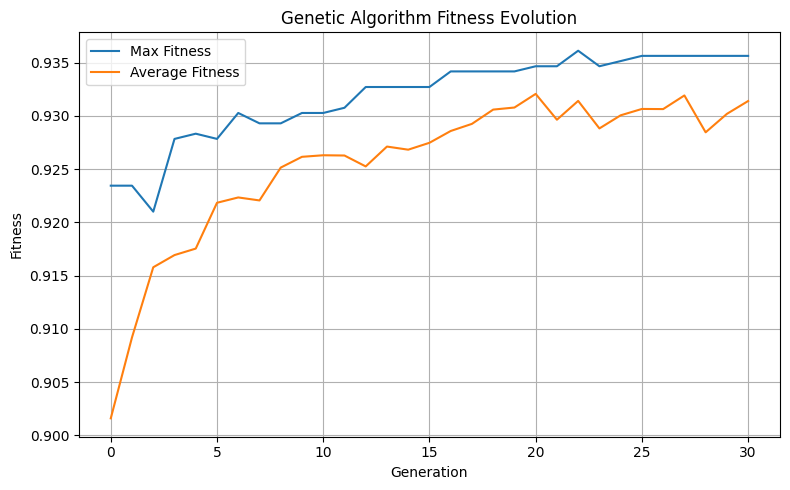

In [ ]:

from deap import base, creator, tools, algorithms
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


# GA setup
N_FEATURES = X_train.shape[1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# GA fitness function with Stratified CV for better generalization
def evaluate_ga(individual):
    selected = [i for i, bit in enumerate(individual) if bit == 1]
    if not selected:
        return 0.0,
    X_sel = X_train[:, selected]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(SVC(kernel='linear', C=1), X_sel, y_train, cv=cv).mean()
    return score,

toolbox.register("evaluate", evaluate_ga)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=40)

stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)

# Run Genetic Algorithm
print("\U0001F680 Running Genetic Algorithm...")
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.3, ngen=30,
                                    stats=stats, verbose=True)

print("\n\U0001F9EC Final GA Population and Fitness Scores:")
for i, ind in enumerate(pop):
    print(f"Individual {i+1}: {ind}")
    print(f"  -> Fitness: {ind.fitness.values[0]:.4f}")

best_ind = tools.selBest(pop, 1)[0]
selected_ga = [i for i, bit in enumerate(best_ind) if bit == 1]
print("\n\U0001F3C5 Best Individual (GA):")
print(f"Binary Mask: {best_ind}")
print(f"Selected Feature Indices: {selected_ga}")
print(f"Number of Features Selected: {len(selected_ga)}")

gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

print("\n\U0001F4C8 Fitness Evolution by Generation:")
for g, max_f, avg_f in zip(gen, max_fitness, avg_fitness):
    print(f"Gen {g:2d} -> Max: {max_f:.4f}, Avg: {avg_f:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(gen, max_fitness, label="Max Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic Algorithm Fitness Evolution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
feature_mask_ga = pd.Series(best_ind, index=X.columns).astype(int)
feature_table_ga = pd.DataFrame({
    'Feature': X.columns,
    'Selected (GA)': feature_mask_ga.values
})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("\n📋 GA Feature Selection Table (Full View):")
print(feature_table_ga)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')




📋 GA Feature Selection Table (Full View):
            Feature  Selected (GA)
0             Order              1
1               PID              1
2       MS SubClass              0
3         MS Zoning              0
4      Lot Frontage              0
5          Lot Area              0
6            Street              1
7         Lot Shape              1
8      Land Contour              1
9         Utilities              1
10       Lot Config              0
11       Land Slope              0
12     Neighborhood              1
13      Condition 1              1
14      Condition 2              0
15        Bldg Type              1
16      House Style              0
17     Overall Qual              1
18     Overall Cond              1
19       Year Built              1
20   Year Remod/Add              1
21       Roof Style              0
22        Roof Matl              1
23     Exterior 1st              1
24     Exterior 2nd              1
25     Mas Vnr Area              1
26       Ext


🔍 Performance on GA-Selected Features

📊 Classification Report for SVM (GA-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.96      0.93      0.94       427
   Expensive       0.93      0.96      0.95       452

    accuracy                           0.95       879
   macro avg       0.95      0.94      0.95       879
weighted avg       0.95      0.95      0.95       879



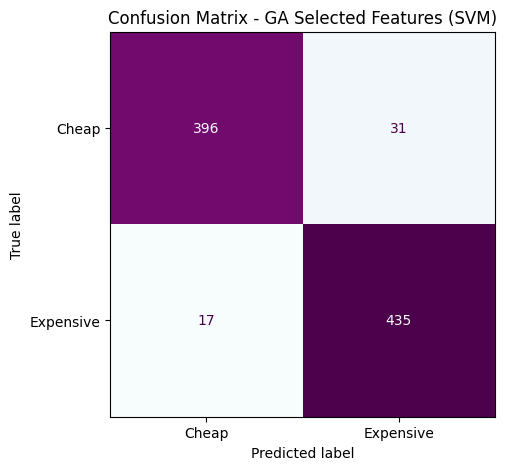


📊 Classification Report for KNN (GA-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.92      0.93      0.93       427
   Expensive       0.94      0.92      0.93       452

    accuracy                           0.93       879
   macro avg       0.93      0.93      0.93       879
weighted avg       0.93      0.93      0.93       879



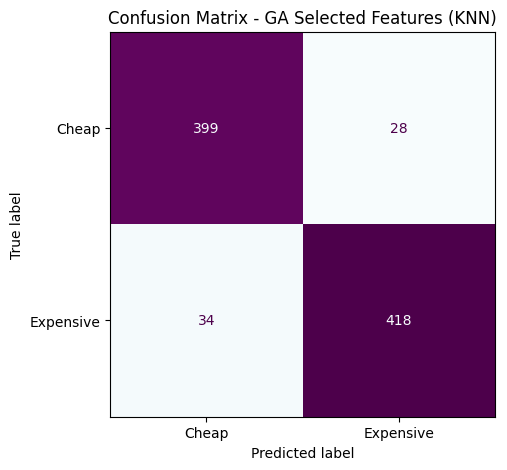


📊 Classification Report for Random Forest (GA-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.94      0.96      0.95       427
   Expensive       0.96      0.95      0.95       452

    accuracy                           0.95       879
   macro avg       0.95      0.95      0.95       879
weighted avg       0.95      0.95      0.95       879



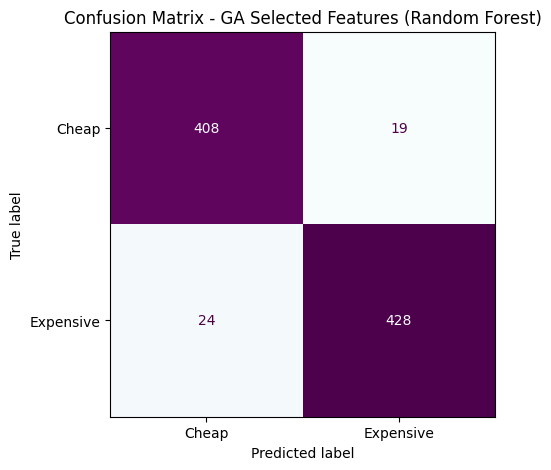


Debug - results_ga structure:
{'SVM': {'accuracy': 0.9453924914675768, 'precision': 0.9334763948497854, 'recall': 0.9623893805309734, 'f1_score': 0.9477124183006536}, 'KNN': {'accuracy': 0.9294653014789533, 'precision': 0.9372197309417041, 'recall': 0.9247787610619469, 'f1_score': 0.9309576837416481}, 'Random Forest': {'accuracy': 0.9510807736063709, 'precision': 0.9574944071588367, 'recall': 0.9469026548672567, 'f1_score': 0.9521690767519466}}

✅ Formatted Results After GA Evaluation:
                       Model  Accuracy  Precision    Recall  F1-score
SVM                      SVM  0.945392   0.933476  0.962389  0.947712
KNN                      KNN  0.929465   0.937220  0.924779  0.930958
Random Forest  Random Forest  0.951081   0.957494  0.946903  0.952169


In [ ]:


print("\n🔍 Performance on GA-Selected Features")
results_ga = {}

for name, model in models.items():
    # Fit and predict using GA-selected features
    model.fit(X_train[:, selected_ga], y_train)
    y_pred = model.predict(X_test[:, selected_ga])

    # Store metrics
    results_ga[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

    # === Classification Report ===
    print(f"\n📊 Classification Report for {name} (GA-Selected Features):")
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='BuPu', colorbar=False)
    plt.title(f"Confusion Matrix - GA Selected Features ({name})")
    plt.show()

# === Convert to DataFrame ===
print("\nDebug - results_ga structure:")
print(results_ga)

ga_results_df = pd.DataFrame(results_ga).T
required_columns = ['accuracy', 'precision', 'recall', 'f1_score']
ga_results_df = ga_results_df[required_columns]
ga_results_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-score']
ga_results_df['Model'] = ga_results_df.index
ga_results_df = ga_results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']]

print("\n✅ Formatted Results After GA Evaluation:")
print(ga_results_df)


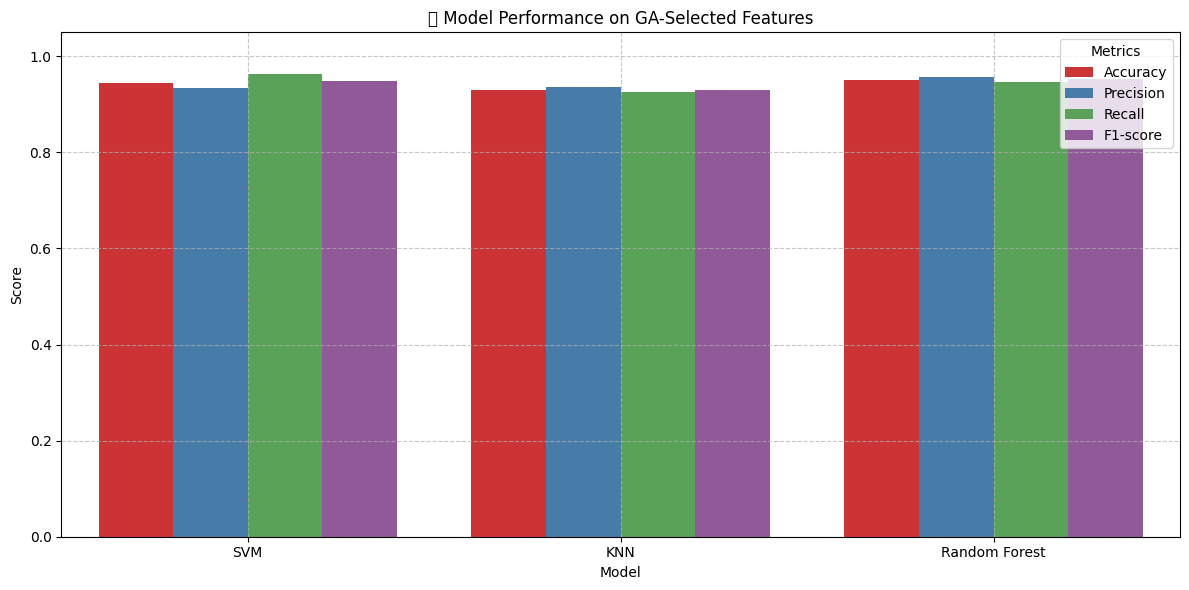

In [ ]:

# --- Visualization of GA Evaluation Results ---
ga_results_melted = ga_results_df.melt(id_vars='Model',
                                       value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'],
                                       var_name='Metric', value_name='Score')

# Plotting the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=ga_results_melted, x='Model', y='Score', hue='Metric', ci=None, palette='Set1')

plt.title('📊 Model Performance on GA-Selected Features')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Metrics')
plt.show()

In [ ]:
!pip install pyswarms


2025-05-17 14:22:52,694 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 2, 'c2': 2, 'w': 0.9}


Running Particle Swarm Optimization...


pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.931
2025-05-17 14:36:03,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9307613791466383, best pos: [  6.81037591  -2.53400129   1.09563602   1.41148834   1.19836645
   0.49582413   1.32431042   0.48585295  -8.36167761   1.8566764
   6.97908478   0.69540436   0.05488278  -0.82434444   4.20173558
  11.89882211   4.91285515   1.54333106   3.85635308   1.36838797
  -0.62241109   1.26338018  13.91030912   2.11425285   4.26814077
   2.12393918   1.9888695    5.82432318   0.73640032   1.80645993
   4.75912696   2.60512966   0.90162917  10.79052384   0.66640645
   4.70915498   1.93458665   3.25387936   1.32831702   2.34280205
   2.31811742   0.40142442   2.10674391  -0.01650372   4.18839254
   4.37033221   1.69009405   6.57579548  -9.28210786   2.82984622
   0.92542199   2.49090563  -7.87134311   2.23149284   0.70674876
   4.62110791   0.84050785   5.52900314   0.98251393   2.5200445
   5.3744324


 Best Particle (PSO):
Binary Mask: [1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0
 1 1]
Selected Feature Indices: [ 0  2  3  4  6  9 10 11 14 15 16 17 18 19 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 42 44 45 46 47 49 50 51 53 54 55 56 57 58
 59 60 63 69 70 74 75]
Number of Features Selected: 55


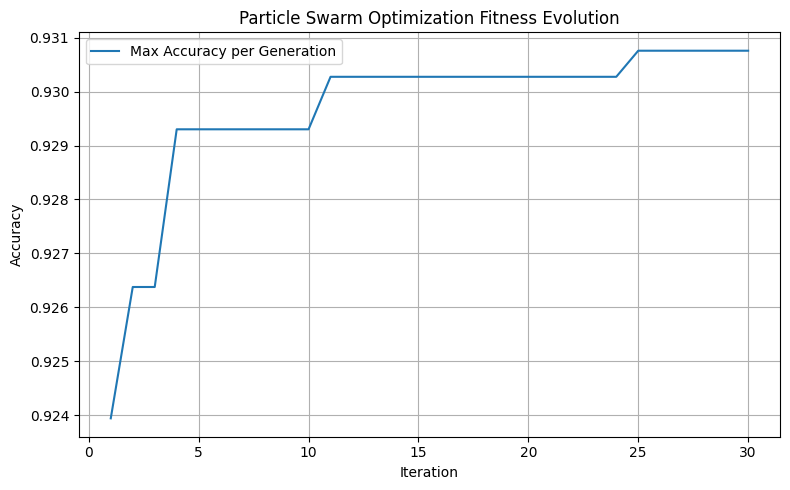

In [ ]:
from pyswarms.single import GlobalBestPSO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

def pso_objective(weights):
    binary_weights = weights > 0.5
    scores = []
    for particle in binary_weights:
        if np.sum(particle) == 0:
            scores.append(0)
        else:
            X_sel = X_train[:, particle]
            clf = SVC(kernel='linear', C=1)
            acc = cross_val_score(clf, X_sel, y_train, cv=5).mean()
            scores.append(-acc)
    return np.array(scores)

n_particles = 30
n_iterations = 30
options = {'c1': 2, 'c2': 2, 'w': 0.9}

# --- Run PSO ---
print("Running Particle Swarm Optimization...")
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=X_train.shape[1], options=options)
cost, pos = optimizer.optimize(pso_objective, iters=n_iterations)

binary_pos = pos > 0.5
selected_pso = np.where(binary_pos)[0]

print("\n Best Particle (PSO):")
print(f"Binary Mask: {binary_pos.astype(int)}")
print(f"Selected Feature Indices: {selected_pso}")
print(f"Number of Features Selected: {len(selected_pso)}")

cost_history = optimizer.cost_history

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_iterations + 1), -np.array(cost_history), label='Max Accuracy per Generation')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Particle Swarm Optimization Fitness Evolution")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

feature_mask_pso = pd.Series(binary_pos, index=X.columns).astype(int)
feature_table_pso = pd.DataFrame({
    'Feature': X.columns,
    'Selected (PSO)': feature_mask_pso.values
})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("\n📋 PSO Feature Selection Table (Full View):")
print(feature_table_pso)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')



📋 PSO Feature Selection Table (Full View):
            Feature  Selected (PSO)
0             Order               1
1               PID               0
2       MS SubClass               1
3         MS Zoning               1
4      Lot Frontage               1
5          Lot Area               0
6            Street               1
7         Lot Shape               0
8      Land Contour               0
9         Utilities               1
10       Lot Config               1
11       Land Slope               1
12     Neighborhood               0
13      Condition 1               0
14      Condition 2               1
15        Bldg Type               1
16      House Style               1
17     Overall Qual               1
18     Overall Cond               1
19       Year Built               1
20   Year Remod/Add               0
21       Roof Style               1
22        Roof Matl               1
23     Exterior 1st               1
24     Exterior 2nd               1
25     Mas Vnr Area 


🔍 Performance on PSO-Selected Features

📊 Classification Report for SVM (PSO-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.95      0.94      0.94       427
   Expensive       0.94      0.95      0.94       452

    accuracy                           0.94       879
   macro avg       0.94      0.94      0.94       879
weighted avg       0.94      0.94      0.94       879



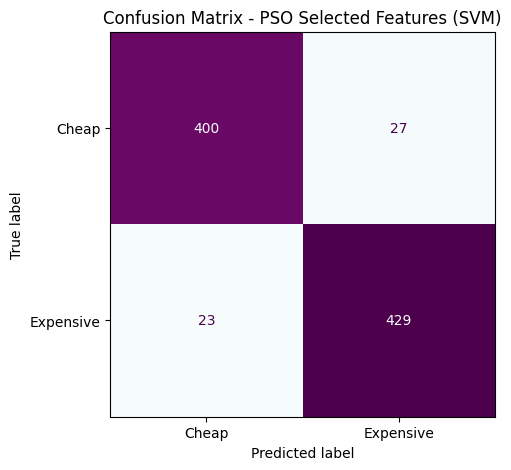


📊 Classification Report for KNN (PSO-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.92      0.93      0.92       427
   Expensive       0.94      0.92      0.93       452

    accuracy                           0.93       879
   macro avg       0.93      0.93      0.93       879
weighted avg       0.93      0.93      0.93       879



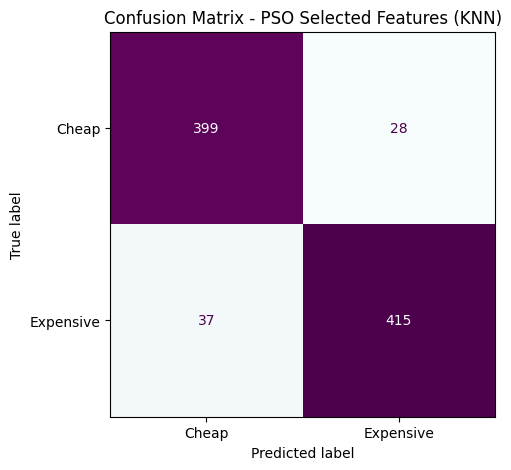


📊 Classification Report for Random Forest (PSO-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.94      0.95      0.95       427
   Expensive       0.95      0.95      0.95       452

    accuracy                           0.95       879
   macro avg       0.95      0.95      0.95       879
weighted avg       0.95      0.95      0.95       879



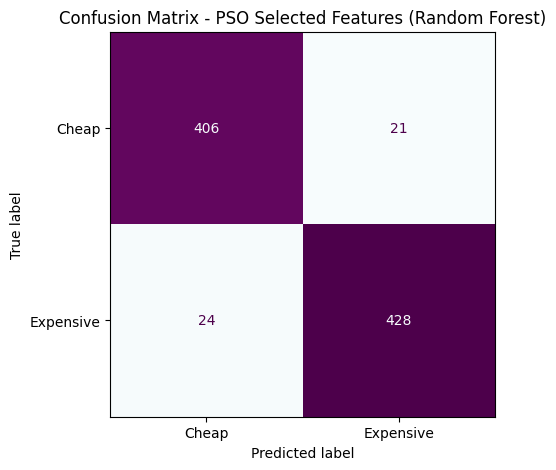


✅ Formatted Results After PSO Evaluation:
                       Model  Accuracy  Precision    Recall  F1-score
SVM                      SVM  0.943117   0.940789  0.949115  0.944934
KNN                      KNN  0.926052   0.936795  0.918142  0.927374
Random Forest  Random Forest  0.948805   0.953229  0.946903  0.950055


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\n🔍 Performance on PSO-Selected Features")
results_pso = {}

for name, model in models.items():
    # Fit and predict using PSO-selected features
    model.fit(X_train[:, selected_pso], y_train)
    y_pred = model.predict(X_test[:, selected_pso])

    # Store metrics
    results_pso[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

    # === Classification Report ===
    print(f"\n📊 Classification Report for {name} (PSO-Selected Features):")
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='BuPu', colorbar=False)
    plt.title(f"Confusion Matrix - PSO Selected Features ({name})")
    plt.show()

# === Convert to DataFrame ===
pso_results_df = pd.DataFrame(results_pso).T
pso_results_df['Model'] = pso_results_df.index
pso_results_df = pso_results_df[['Model', 'accuracy', 'precision', 'recall', 'f1_score']]
pso_results_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']

print("\n✅ Formatted Results After PSO Evaluation:")
print(pso_results_df)


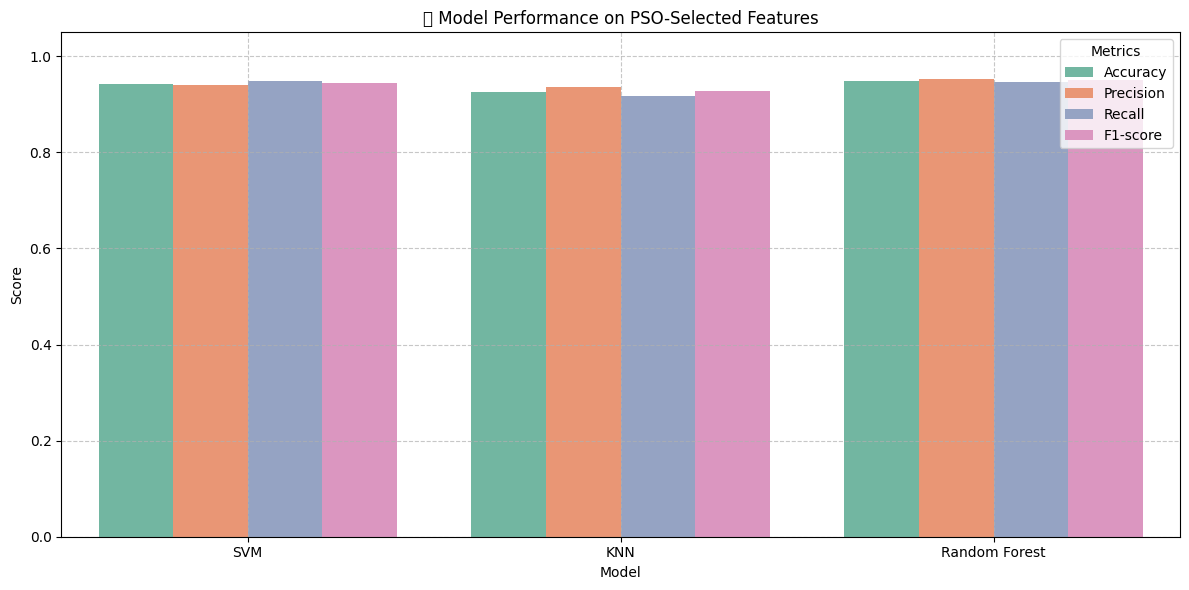

In [ ]:
# --- Visualization of PSO Evaluation Results ---
pso_results_melted = pso_results_df.melt(id_vars='Model',
                                         value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'], # Changed to uppercase
                                         var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=pso_results_melted, x='Model', y='Score', hue='Metric', ci=None, palette='Set2')

plt.title('📊 Model Performance on PSO-Selected Features')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Metrics')
plt.show()


 Final Comparison of Model Performance Across Feature Sets:
           Model  accuracy  precision    recall  f1_score   Feature Set
0            SVM  0.939704   0.936543  0.946903  0.941694  All Features
1            KNN  0.922639   0.942396  0.904867  0.923251  All Features
2  Random Forest  0.952218   0.963801  0.942478  0.953020  All Features
3            SVM  0.945392   0.933476  0.962389  0.947712   GA Selected
4            KNN  0.929465   0.937220  0.924779  0.930958   GA Selected
5  Random Forest  0.951081   0.957494  0.946903  0.952169   GA Selected
6            SVM  0.943117   0.940789  0.949115  0.944934  PSO Selected
7            KNN  0.926052   0.936795  0.918142  0.927374  PSO Selected
8  Random Forest  0.948805   0.953229  0.946903  0.950055  PSO Selected


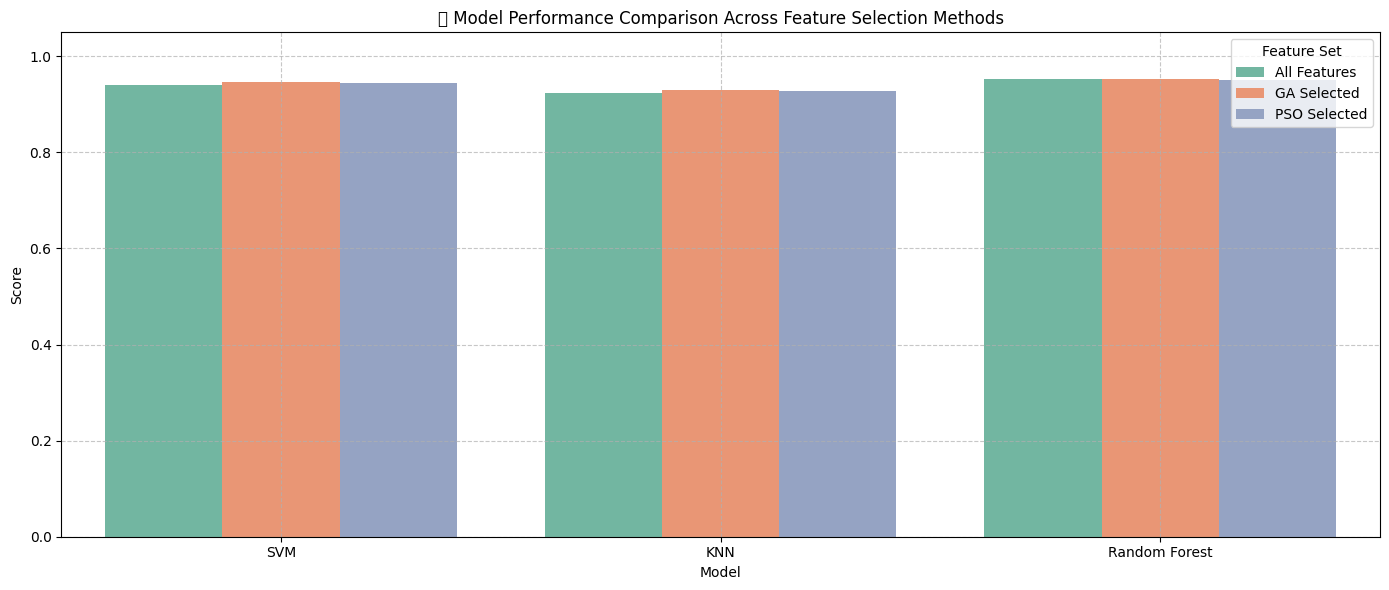

In [ ]:
# === Combine and Compare Results ===
df_all = pd.DataFrame(results_all).T
df_all['Feature Set'] = 'All Features'

df_ga = pd.DataFrame(results_ga).T
df_ga['Feature Set'] = 'GA Selected'

df_pso = pd.DataFrame(results_pso).T
df_pso['Feature Set'] = 'PSO Selected'
results_df = pd.concat([df_all, df_ga, df_pso])
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model'}, inplace=True)

print("\n Final Comparison of Model Performance Across Feature Sets:")
print(results_df)

# === Visualization of Results ===
results_melted = results_df.melt(
    id_vars=['Model', 'Feature Set'],
    value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
    var_name='Metric',
    value_name='Score'
)


plt.figure(figsize=(14, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Feature Set', ci=None, palette='Set2')
plt.title('📈 Model Performance Comparison Across Feature Selection Methods')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Feature Set')
plt.show()


In [ ]:
def predict_sample_with_models(models, sample, feature_names, selected_mask, label_map, set_name):
    print(f"\n{'='*40}\n🔍 Predictions using {set_name}\n{'='*40}")

    # Prepare input based on feature selection
    selected_features = feature_names[selected_mask] if isinstance(selected_mask, (list, np.ndarray)) else feature_names
    input_vector = sample[selected_features].values.reshape(1, -1)

    for model_name, model in models.items():
        pred = model.predict(input_vector)[0]
        print(f"🔹 {model_name}: {label_map[pred]}")


In [ ]:
# Example new sample
new_sample_dict = {
    'MS SubClass': 20,
    'MS Zoning': 1,
    'Lot Frontage': 80,
    'Lot Area': 9600,
    'Street': 1,
    'Lot Shape': 0,
    'Land Contour': 0,
    'Utilities': 0,
    'Lot Config': 1,
    'Land Slope': 0,
    'Neighborhood': 5,
    'Condition 1': 0,
    'Condition 2': 0,
    'Bldg Type': 0,
    'House Style': 1,
    'Overall Qual': 7,
    'Overall Cond': 5,
    'Year Built': 2003,
    'Year Remod/Add': 2003,
    'Roof Style': 1,
    'Roof Matl': 0,
    'Exterior 1st': 2,
    'Exterior 2nd': 2,
    'Mas Vnr Area': 196,
    'Exter Qual': 2,
    'Exter Cond': 1,
    'Foundation': 2,
    'Bsmt Qual': 3,
    'Bsmt Cond': 1,
    'Bsmt Exposure': 0,
    'BsmtFin Type 1': 2,
    'BsmtFin SF 1': 706,
    'BsmtFin Type 2': 1,
    'BsmtFin SF 2': 0,
    'Bsmt Unf SF': 150,
    'Total Bsmt SF': 856,
    'Heating': 1,
    'Heating QC': 4,
    'Central Air': 1,
    'Electrical': 1,
    '1st Flr SF': 856,
    '2nd Flr SF': 854,
    'Low Qual Fin SF': 0,
    'Gr Liv Area': 1710,
    'Bsmt Full Bath': 1,
    'Bsmt Half Bath': 0,
    'Full Bath': 2,
    'Half Bath': 1,
    'Bedroom AbvGr': 3,
    'Kitchen AbvGr': 1,
    'Kitchen Qual': 3,
    'TotRms AbvGrd': 7,
    'Functional': 0,
    'Fireplaces': 1,
    'Fireplace Qu': 1,
    'Garage Type': 2,
    'Garage Yr Blt': 2003,
    'Garage Finish': 1,
    'Garage Cars': 2,
    'Garage Area': 548,
    'Garage Qual': 1,
    'Garage Cond': 1,
    'Paved Drive': 1,
    'Wood Deck SF': 200,
    'Open Porch SF': 60,
    'Enclosed Porch': 0,
    '3Ssn Porch': 0,
    'Screen Porch': 120,
    'Pool Area': 0,
    'Misc Val': 0,
    'Mo Sold': 6,
    'Yr Sold': 2009,
    'Sale Type': 0,
    'Sale Condition': 0
}

new_sample_df = pd.DataFrame([new_sample_dict])



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def predict_all_models(new_sample_df, scaler, models, selected_ga, selected_pso, X_train, y_train):
    predictions = {}
    original_feature_cols = X.columns # Assuming X is the DataFrame before train/test split

    if not new_sample_df.columns.equals(X.columns):
         # This is a robust way to ensure column alignment
        new_sample_df = new_sample_df.reindex(columns=X.columns, fill_value=0) # Fill missing with 0, adjust if needed
    new_sample_scaled = scaler.transform(new_sample_df)


    # All features
    for name, model in models.items():
        model.fit(X_train, y_train)
        # Predict on the scaled new sample data (all features)
        pred = model.predict(new_sample_scaled)[0]
        predictions[f"{name} (All)"] = int(pred)
    new_sample_ga_scaled = new_sample_scaled[:, selected_ga]
    for name, model in models.items():
        # Re-train on GA-selected *scaled* training data
        model.fit(X_train[:, selected_ga], y_train)
        # Predict on the GA-selected *scaled* new sample data
        pred = model.predict(new_sample_ga_scaled)[0]
        predictions[f"{name} (GA)"] = int(pred)
    new_sample_pso_scaled = new_sample_scaled[:, selected_pso]
    for name, model in models.items():
        model.fit(X_train[:, selected_pso], y_train)
        pred = model.predict(new_sample_pso_scaled)[0]
        predictions[f"{name} (PSO)"] = int(pred)


    return predictions

In [ ]:

predictions = predict_all_models(new_sample_df, scaler, models, selected_ga, selected_pso, X_train, y_train)
print("\n📈 Predictions on New Sample:")
label_map = classes
for model_name, pred_int in predictions.items():
    pred_label = label_map.get(pred_int, f"Unknown ({pred_int})")
    print(f"{model_name}: {pred_label}")


📈 Predictions on New Sample:
SVM (All): Expensive
KNN (All): Cheap
Random Forest (All): Expensive
SVM (GA): Expensive
KNN (GA): Expensive
Random Forest (GA): Expensive
SVM (PSO): Expensive
KNN (PSO): Cheap
Random Forest (PSO): Expensive
